In [ ]:
from sklearn.datasets import load_breast_cancer
cancer = load_breast_cancer()

print(cancer.data.shape)

from sklearn.model_selection import train_test_split
x = cancer.data
y = cancer.target
x_train_all, x_test, y_train_all, y_test = train_test_split(x, y, stratify = y, test_size = 0.2, random_state = 42)
x_train, x_val, y_train, y_val = train_test_split(x_train_all, y_train_all, stratify = y_train_all, test_size = 0.25, random_state = 42)
print(len(x_train), len(x_val), len(x_test))

import numpy as np
train_mean = np.mean(x_train, axis = 0)
train_std = np.std(x_train, axis = 0)



# Normalize training set using train mean and std
X_train = (x_train - train_mean) / train_std

# Normalize validation set using train mean and std
X_val = (x_val - train_mean) / train_std
# X_val = (x_val - val_mean) / val_std
# Normalize test set using train mean and std
X_test = (x_test - train_mean) / train_std


(569, 30)
341 114 114


### hidden layer relu batch gradient method

In [ ]:
import numpy as np

class MultiLayerReLU:

    def __init__(self, hidden_units1=10, hidden_units2=5, learning_rate=0.1, l1=0, l2=0):
        self.hidden_units1 = hidden_units1  # 첫 번째 은닉층의 뉴런 개수
        self.hidden_units2 = hidden_units2  # 두 번째 은닉층의 뉴런 개수
        self.w1 = None    # 첫 번째 은닉층 가중치
        self.b1 = None    # 첫 번째 은닉층 절편
        self.w2 = None    # 두 번째 은닉층 가중치
        self.b2 = None    # 두 번째 은닉층 절편
        self.w3 = None    # 출력층 가중치
        self.b3 = None    # 출력층 절편
        self.a1 = None    # 첫 번째 은닉층 활성화 값
        self.a2 = None    # 두 번째 은닉층 활성화 값
        self.lr = learning_rate
        self.l1 = l1
        self.l2 = l2
        self.losses = []       # 에포크별 훈련 손실 저장 리스트
        self.val_losses = []   # 에포크별 검증 손실 저장 리스트

    def relu(self, z):
        """ReLU 활성화 함수"""
        return np.maximum(0, z)

    def relu_derivative(self, z):
        """ReLU 활성화 함수의 미분"""
        return np.where(z > 0, 1, 0)

    def forpass(self, x):
        # 첫 번째 은닉층
        z1 = np.dot(x, self.w1) + self.b1
        self.a1 = self.relu(z1)  # ReLU 적용
        # 두 번째 은닉층
        z2 = np.dot(self.a1, self.w2) + self.b2
        self.a2 = self.relu(z2)  # ReLU 적용
        # 출력층 (여기서는 sigmoid 사용)
        z3 = np.dot(self.a2, self.w3) + self.b3
        return z3

    def backprop(self, x, err):
        m = len(x)
        # 출력층에 대한 그래디언트
        w3_grad = np.dot(self.a2.T, err) / m
        b3_grad = np.sum(err) / m
        # 두 번째 은닉층에 대한 그래디언트
        err_hidden2 = np.dot(err, self.w3.T) * self.relu_derivative(self.a2)
        w2_grad = np.dot(self.a1.T, err_hidden2) / m
        b2_grad = np.sum(err_hidden2, axis=0) / m
        # 첫 번째 은닉층에 대한 그래디언트
        err_hidden1 = np.dot(err_hidden2, self.w2.T) * self.relu_derivative(self.a1)
        w1_grad = np.dot(x.T, err_hidden1) / m
        b1_grad = np.sum(err_hidden1, axis=0) / m
        return w1_grad, b1_grad, w2_grad, b2_grad, w3_grad, b3_grad

    def init_weights(self, n_features):
        # 가중치와 절편 초기화
        self.w1 = np.random.randn(n_features, self.hidden_units1) * 0.01
        self.b1 = np.zeros(self.hidden_units1)
        self.w2 = np.random.randn(self.hidden_units1, self.hidden_units2) * 0.01
        self.b2 = np.zeros(self.hidden_units2)
        self.w3 = np.random.randn(self.hidden_units2, 1) * 0.01
        self.b3 = 0

    def fit(self, x, y, epochs=100, x_val=None, y_val=None, patience=10):
        y = y.reshape(-1, 1)
        y_val = y_val.reshape(-1, 1)
        m = len(x)

        # 가중치 초기화
        self.init_weights(x.shape[1])

        # Early stopping을 위한 변수 초기화
        best_val_loss = float('inf')  # 가장 낮은 검증 손실값을 저장할 변수
        patience_counter = 0          # patience 횟수를 세는 변수

        for i in range(epochs):
            a = self.training(x, y, m)
            a = np.clip(a, 1e-10, 1-1e-10)
            loss = np.sum(-(y * np.log(a) + (1 - y) * np.log(1 - a)))
            self.losses.append((loss + self.reg_loss()) / m)  # 훈련 손실 저장
            self.update_val_loss(x_val, y_val)  # 검증 손실 업데이트

            # Early Stopping 검증 로직
            current_val_loss = self.val_losses[-1]  # 현재 검증 손실

            if current_val_loss < best_val_loss:
                best_val_loss = current_val_loss  # 가장 낮은 검증 손실 갱신
                patience_counter = 0  # patience 카운터 초기화
            else:
                patience_counter += 1  # 개선이 없으면 카운터 증가

            if patience_counter >= patience:
                print(f"Early stopping at epoch {i+1}")
                break  # patience 초과 시 학습 중단

    def training(self, x, y, m):
        z = self.forpass(x)
        a = self.activation(z)
        err = -(y - a)
        w1_grad, b1_grad, w2_grad, b2_grad, w3_grad, b3_grad = self.backprop(x, err)
        w1_grad += (self.l1 * np.sign(self.w1) + self.l2 * self.w1) / m
        w2_grad += (self.l1 * np.sign(self.w2) + self.l2 * self.w2) / m
        w3_grad += (self.l1 * np.sign(self.w3) + self.l2 * self.w3) / m
        # 가중치 업데이트
        self.w1 -= self.lr * w1_grad
        self.b1 -= self.lr * b1_grad
        self.w2 -= self.lr * w2_grad
        self.b2 -= self.lr * b2_grad
        self.w3 -= self.lr * w3_grad
        self.b3 -= self.lr * b3_grad
        return a

    def activation(self, z):
        return 1 / (1 + np.exp(-z))  # 출력층에서는 여전히 sigmoid 사용

    def reg_loss(self):
        return self.l1 * (np.sum(np.abs(self.w1)) + np.sum(np.abs(self.w2)) + np.sum(np.abs(self.w3))) + \
               self.l2 / 2 * (np.sum(self.w1**2) + np.sum(self.w2**2) + np.sum(self.w3**2))

    def update_val_loss(self, x_val, y_val):
        z = self.forpass(x_val)
        a = self.activation(z)
        a = np.clip(a, 1e-10, 1-1e-10)
        val_loss = np.sum(-(y_val * np.log(a) + (1 - y_val) * np.log(1 - a)))
        self.val_losses.append((val_loss + self.reg_loss()) / len(y_val))  # 검증 손실 저장

    ### predict 함수 추가
    def predict(self, X):
        predictions = self.forpass(X)
        return (self.activation(predictions) > 0.5).astype(int)

    ### score 함수 추가
    def score(self, X, y):
        predictions = self.predict(X)
        accuracy = np.mean(predictions == y.reshape(-1, 1))
        return accuracy


In [ ]:
# 모델 학습
model = MultiLayerReLU(hidden_units1=16, hidden_units2=32, learning_rate=0.01, l2=0.01)
model.fit(X_train, y_train, epochs=1000, x_val=X_val, y_val=y_val, patience=10)

accuracy = model.score(X_test, y_test)
print(f"Test set accuracy: {accuracy}")

Test set accuracy: 0.631578947368421


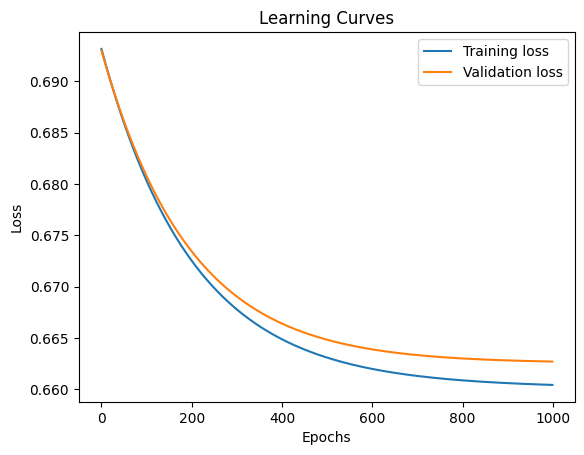

In [ ]:
import matplotlib.pyplot as plt

def plot_learning_curves(model):
    plt.plot(model.losses, label='Training loss')
    plt.plot(model.val_losses, label='Validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Learning Curves')
    plt.show()

# 모델을 학습한 후 호출
# model은 MultiLayer 클래스의 인스턴스라고 가정
plot_learning_curves(model)

### relu사용한 2 hidden layer stohastic gradient method

In [ ]:
import numpy as np

class MultiLayerReLU2:

    def __init__(self, hidden_units1=10, hidden_units2=5, learning_rate=0.1, l1=0, l2=0):
        self.hidden_units1 = hidden_units1  # 첫 번째 은닉층의 뉴런 개수
        self.hidden_units2 = hidden_units2  # 두 번째 은닉층의 뉴런 개수
        self.w1 = None    # 첫 번째 은닉층 가중치
        self.b1 = None    # 첫 번째 은닉층 절편
        self.w2 = None    # 두 번째 은닉층 가중치
        self.b2 = None    # 두 번째 은닉층 절편
        self.w3 = None    # 출력층 가중치
        self.b3 = None    # 출력층 절편
        self.a1 = None    # 첫 번째 은닉층 활성화 값
        self.a2 = None    # 두 번째 은닉층 활성화 값
        self.lr = learning_rate
        self.l1 = l1
        self.l2 = l2
        self.losses = []       # 에포크별 훈련 손실 저장 리스트
        self.val_losses = []   # 에포크별 검증 손실 저장 리스트

    def relu(self, z):
        """ReLU 활성화 함수"""
        return np.maximum(0, z)

    def relu_derivative(self, z):
        """ReLU 활성화 함수의 미분"""
        return np.where(z > 0, 1, 0)

    def forpass(self, x):
        # 첫 번째 은닉층
        z1 = np.dot(x, self.w1) + self.b1
        self.a1 = self.relu(z1)  # ReLU 적용
        # 두 번째 은닉층
        z2 = np.dot(self.a1, self.w2) + self.b2
        self.a2 = self.relu(z2)  # ReLU 적용
        # 출력층 (여기서는 sigmoid 사용)
        z3 = np.dot(self.a2, self.w3) + self.b3
        return z3

    def backprop(self, x, err):
        m = len(x)
        # 출력층에 대한 그래디언트
        w3_grad = np.dot(self.a2.T, err) / m
        b3_grad = np.sum(err) / m
        # 두 번째 은닉층에 대한 그래디언트
        err_hidden2 = np.dot(err, self.w3.T) * self.relu_derivative(self.a2)
        w2_grad = np.dot(self.a1.T, err_hidden2) / m
        b2_grad = np.sum(err_hidden2, axis=0) / m
        # 첫 번째 은닉층에 대한 그래디언트
        err_hidden1 = np.dot(err_hidden2, self.w2.T) * self.relu_derivative(self.a1)
        w1_grad = np.dot(x.T, err_hidden1) / m
        b1_grad = np.sum(err_hidden1, axis=0) / m
        return w1_grad, b1_grad, w2_grad, b2_grad, w3_grad, b3_grad

    def init_weights(self, n_features):
        # 가중치와 절편 초기화
        self.w1 = np.random.randn(n_features, self.hidden_units1) * 0.01
        self.b1 = np.zeros(self.hidden_units1)
        self.w2 = np.random.randn(self.hidden_units1, self.hidden_units2) * 0.01
        self.b2 = np.zeros(self.hidden_units2)
        self.w3 = np.random.randn(self.hidden_units2, 1) * 0.01
        self.b3 = 0

    def fit(self, x, y, epochs=100, x_val=None, y_val=None):
        y = y.reshape(-1, 1)
        y_val = y_val.reshape(-1, 1)
        m = len(x)
        self.init_weights(x.shape[1])
        for i in range(epochs):
            indices = np.random.permutation(m)  # 데이터 셔플
            for idx in indices:  # 각 데이터 포인트마다 학습
                xi = x[idx:idx+1]
                yi = y[idx:idx+1]
                a = self.training(xi, yi, 1)  # 한 샘플에 대해 학습
            # 손실 계산
            a = np.clip(a, 1e-10, 1-1e-10)
            loss = np.sum(-(y * np.log(a) + (1 - y) * np.log(1 - a)))
            self.losses.append((loss + self.reg_loss()) / m)
            self.update_val_loss(x_val, y_val)

    def training(self, x, y, m):
        z = self.forpass(x)
        a = self.activation(z)
        err = -(y - a)
        w1_grad, b1_grad, w2_grad, b2_grad, w3_grad, b3_grad = self.backprop(x, err)
        w1_grad += (self.l1 * np.sign(self.w1) + self.l2 * self.w1) / m
        w2_grad += (self.l1 * np.sign(self.w2) + self.l2 * self.w2) / m
        w3_grad += (self.l1 * np.sign(self.w3) + self.l2 * self.w3) / m
        # 가중치 업데이트
        self.w1 -= self.lr * w1_grad
        self.b1 -= self.lr * b1_grad
        self.w2 -= self.lr * w2_grad
        self.b2 -= self.lr * b2_grad
        self.w3 -= self.lr * w3_grad
        self.b3 -= self.lr * b3_grad
        return a

    def activation(self, z):
        return 1 / (1 + np.exp(-z))  # 출력층에서는 여전히 sigmoid 사용

    def reg_loss(self):
        return self.l1 * (np.sum(np.abs(self.w1)) + np.sum(np.abs(self.w2)) + np.sum(np.abs(self.w3))) + \
               self.l2 / 2 * (np.sum(self.w1**2) + np.sum(self.w2**2) + np.sum(self.w3**2))

    def update_val_loss(self, x_val, y_val):
        z = self.forpass(x_val)
        a = self.activation(z)
        a = np.clip(a, 1e-10, 1-1e-10)
        val_loss = np.sum(-(y_val * np.log(a) + (1 - y_val) * np.log(1 - a)))
        self.val_losses.append((val_loss + self.reg_loss()) / len(y_val))  # 검증 손실 저장

    ### predict 함수 추가
    def predict(self, X):
        predictions = self.forpass(X)
        return (self.activation(predictions) > 0.5).astype(int)

    ### score 함수 추가
    def score(self, X, y):
        predictions = self.predict(X)
        accuracy = np.mean(predictions == y.reshape(-1, 1))
        return accuracy


In [ ]:
# 모델 학습
model2 = MultiLayerReLU2(hidden_units1=16, hidden_units2=32, learning_rate=0.001, l2=0.01)
model2.fit(X_train, y_train, epochs=60, x_val=X_val, y_val=y_val)

accuracy = model2.score(X_test, y_test)
print(f"Test set accuracy: {accuracy}")

Test set accuracy: 0.631578947368421


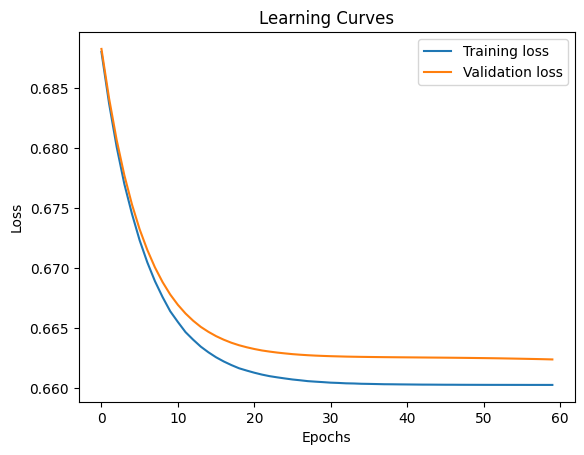

In [ ]:
import matplotlib.pyplot as plt


# 학습 손실과 검증 손실 플롯
plt.plot(model2.losses, label='Training loss')
plt.plot(model2.val_losses, label='Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Learning Curves')
plt.show()